## Preliminary Analysis
Mainly to get a general idea of the data set and which feature might be useful

In [2]:
# General useful imports from previous homework
import numpy as np
import matplotlib.pyplot as plt
import librosa 
import librosa.display
from IPython.display import Audio
from scipy import signal
from scipy.signal import find_peaks, windows
%matplotlib inline

# Basic audio parameters

SR            = 22050                  #  sample rate default for Librosa

# Utility functions

# Round to 4 decimal places

def round4(x):
    return np.around(x,4)   

import soundfile as sf
import io
import warnings

from six.moves.urllib.request import urlopen

def readSignal(name,sr=None):    
    if(name[:5] == 'https'):
        with warnings.catch_warnings():
            warnings.simplefilter("ignore")
            X, fileSR = sf.read(io.BytesIO(urlopen(name).read()))           
    else:
        with warnings.catch_warnings():
            warnings.simplefilter("ignore")
            X, fileSR = librosa.load(name)
    if((sr == None) or (fileSR == sr)):
        return X
    else:
        return librosa.resample(X,fileSR,SR) 
    
def displaySignal(X, sr=SR, title='Signal Window for X',x_units = "Seconds", figsize=(14,6),gridlines=False): 
    
    if(x_units == "Seconds"):
        T = np.arange(0, len(X)/sr, 1/sr)
    elif(x_units == "Milliseconds"):
        T = np.arange(0, 1000*len(X)/sr, 1000/sr)
    elif(x_units == "Samples"):
        T = np.arange(len(X))

    plt.figure(figsize=figsize)   # Set x and y dimensions of window: may need to redo for your display
    plt.title(title, fontsize=14, fontweight='bold')
    if(x_units=="Samples"):
        plt.xlabel("Sample Number")
    else:
        plt.xlabel(x_units)
    plt.ylabel("Amplitude")
    plt.ylim([-1.1,1.1])
    plt.plot([0,T[-1]],[0,0],color='black')      # draw the 0 line in black
    plt.plot(T,X)                    
    plt.grid(gridlines)                     # if you want dotted grid lines
    plt.show()
    
# display the waveform using librosa

def displaySignal2(x,sr=SR,title='Signal X',):
    plt.figure(figsize=(12,6))
    plt.title(title)
    plt.ylim([-1.1,1.1])           # if you want the full range -1 .. 1, else will adapt to signal
    plt.plot([0,librosa.get_duration(x)],[0,0],linewidth=1,color='k') # if you want a 0 line
    #plt.grid()                    # if you want gridlines
    librosa.display.waveshow(x,sr=sr)
    plt.show()

def realFFT(X):
    return 2*abs(np.fft.rfft(X))/len(X) 

def normalize(X):
    X_max = max(X)
    return X/X_max

Audio text: Please call Stella.  Ask her to bring these things with her from the store:  Six spoons of fresh snow peas, five thick slabs of blue cheese, and maybe a snack for her brother Bob.  We also need a small plastic snake and a big toy frog for the kids.  She can scoop these things into three red bags, and we will go meet her Wednesday at the train station.

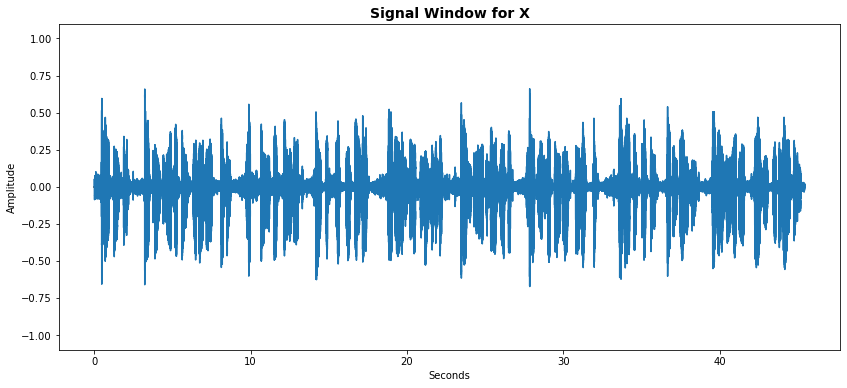

In [3]:
audio_test = readSignal("archive/recordings/recordings/arabic1.mp3")
displaySignal(audio_test)
Audio(audio_test,rate=SR)

In [4]:
# test it with the avg filter from problem set 2
# reduce background noise: when K=50 it works the best
def applyFilter1(W,X):
    q = len(W)-1
    result = np.zeros(len(X)+q)
    zeros = np.zeros(q)
    X = np.concatenate((zeros,X))
    X = np.concatenate((X,zeros))
    i=0
    for k in range(q,len(X)):
        result[i] = W @ X[k-q:k+1]
        i+=1
    return result
def makeAvgFilter(K):
    return [1/K for _ in range(K)]
def applyAvgFilter(K, signal):
    trim = int((K-1)/2) # = n
    length = len(signal)
    signal = signal[trim:length-trim]
    return applyFilter1(makeAvgFilter(K),signal)

In [5]:
def rectify(A):
    return np.maximum(A,np.zeros(len(A)))

# S is previous spectrum, Sn is next one

def spectral_distance(S,Sn,kind='L2'):      # default is L2 norm
    S = np.abs(S)          # just use magnitude of complex values
    Sn = np.abs(Sn)
    if(kind == 'L1'):
        return np.sum(np.abs(Sn-S))
    elif(kind == 'L2'):
        return (np.sum((Sn-S)**2))**0.5
    elif(kind == 'CD'):                     # Correlation Distance:  1 - correlation
        s = np.std(S)                       # must account for spectra with all 0's
        sn = np.std(Sn)
        if(np.isclose(s,0) or np.isclose(sn,0)):
            return 0.0
        else:
            return 1.0 - (((S - np.mean(S)) @ (Sn - np.mean(Sn))) / (len(S) * s * sn))
    elif(kind == 'RL1'):
        return np.sum(np.abs(rectify(Sn-S)))
    elif(kind == 'RL2'):
        return (np.sum(rectify(Sn-S)**2))**0.5               
    else:
        return None
def movingAverageFilter(X,n=3):    
    Y = np.copy(X)
    for i in range(n//2,len(X)-n//2):
        Y[i] = np.mean(X[i-n//2:i+n//2+1])
    return Y

    
# Replace each X[i] by its difference from the mean of the surrounding
# n points

def subtractMAFilter(X,n=3):
    Y = np.copy(X)
    return Y - movingAverageFilter(X,n)

# Apply a median smoothing filter to X, starting at index n/2 and ending
# at len(X)-n/2-1, returning a new smoothed array;
    
def medianFilter(X,n=3):    
    Y = np.copy(X)
    for i in range(n//2,len(X)-n//2):
        Y[i] = np.median(X[i-n//2:i+n//2+1])
    return Y

# To emphasize peaks, subtract the smoothed curve from the original
    
def subtractMedianFilter(X,n=3):
    Y = np.copy(X)
    return Y - medianFilter(X,n)

def applyFilter(X,kind=None,size=3):
    if(kind == 'MAF'):
        return movingAverageFilter(X,size)
    elif(kind == 'sMAF'):
        return subtractMAFilter(X,size)
    elif(kind == 'MF'):
        return medianFilter(X,size)
    elif(kind == 'sMF'):
        return subtractMedianFilter(X,size)
    
def SpectralBasedOnsets(X,window_size=512,hop_length=256,
                        kind = None,     # distance function used, L1, L2, CD, SF1, SF2
                        filtr = None,    # filter applied before peak picking, if any, from ('MAF','sMAF','MF','sMF')
                        size = 3,        # size of kernel used in filter, if any
                        win = None,      # apply windowing function to window, if any ('hann','tri')
                        scale=None,      # scale factor for log, None = no log
                        height=None,     # these 3 parameters are for pick_peak,
                        prominence=None, #    any not equal to None will be applied
                        distance=None,
                        displayAll=False):  
    maxnote = max(abs(X))
    norm_X = X/maxnote
    X_FFT = []    
    for i in range(0,len(X),hop_length):
        
        if i+window_size > len(X):
            break
        else:
            seg = norm_X[i:i+window_size]
            if(win):
                seg = win(len(seg))*seg
            seg_FFT = realFFT(seg)
            
        X_FFT.append(seg_FFT)
    X_FFT = np.array(X_FFT)
    X_FFT_log = []    
    if(scale):
        X_FFT_log = np.log(1.0+ scale*X_FFT)
    else:
        X_FFT_log = X_FFT
    if(displayAll):
        plt.figure(figsize=(12,4))
        plt.title("Log X Energy Signal with scale factor "+str(scale))
        plt.plot(X_FFT_log)
        plt.show()
    X_spectral_novelty = np.zeros(len(X_FFT_log))
    for k in range(1,len(X_FFT_log)):           #first value will be 0, length unchanged
        X_spectral_novelty[k] = spectral_distance(X_FFT_log[k-1],X_FFT_log[k],kind)
    if(displayAll):
        plt.figure(figsize=(12,4))
        plt.title("X FFT Novelty")
        plt.plot(X_spectral_novelty)
        plt.show()
    X_spectral_novelty_rectified = []    
    X_spectral_novelty_rectified = rectify(X_spectral_novelty)
    X_max = max(X_spectral_novelty_rectified)
    X_spectral_novelty_rectified = X_spectral_novelty_rectified/X_max
    if(displayAll):
        plt.figure(figsize=(12,4))
        plt.title("Rectified X Energy Novelty")
        plt.plot(X_spectral_novelty_rectified)
        plt.show()
    if(filtr):
        applyFilter(X_spectral_novelty_rectified,filtr,size)
    peaks,_ = find_peaks(X_spectral_novelty_rectified,height=height,prominence=prominence,distance=distance)    
    if(displayAll):
        plt.figure(figsize=(12,4))
        plt.title("Picking Peaks")
        plt.plot(peaks, X_spectral_novelty_rectified[peaks], "or")
        plt.plot(X_spectral_novelty_rectified)
        plt.show()
    onsets = []    
    for i in peaks:
        onsets.append(i*hop_length+window_size//2)
    onsets = np.array(onsets)
    if(displayAll):
        plt.figure(figsize=(12,4))
        plt.title("Signal with Onsets")
        plt.plot(X)  
        for k in range(len(onsets)):
            plt.plot([onsets[k],onsets[k]],[-1,1],color='r')    
        plt.show()
    clicks = librosa.clicks(times=onsets/SR, sr=SR, hop_length=hop_length, length=len(X))
    return (onsets,clicks)

In [6]:
# find the envolope from problem set 1
def getAmplitudeEnvelope(X, window_size=441, overlap=0.5):
    last_amp = 0
    result = []
    i = 0
    while i<len(X):
        sub_result = []
        if i+window_size <= len(X):
            temp = np.max(np.abs(X[i:i+window_size]))
            sub_result = np.full(int(window_size*(1-overlap)),temp)
            #sub_result = np.linspace(last_amp,temp,int(window_size*(1-overlap)))
            result = np.concatenate([result,sub_result]) 
            last_amp = temp
        elif i+int(window_size*(1-overlap))<=len(X):
            temp = np.max(np.abs(X[i:]))
            #sub_result = np.linspace(last_amp,temp,int(window_size*(1-overlap)))
            sub_result = np.full(int(window_size*(1-overlap)),temp)
            result = np.concatenate([result,sub_result])
        else:
            temp = np.max(np.abs(X[i:]))
            #sub_result = np.linspace(last_amp,temp,len(X)-i)
            sub_result = np.full(len(X)-i,temp)
            result = np.concatenate([result,sub_result])
        i += int(window_size*(1-overlap))
    return result


In [7]:
def pre_analysis(X):
    # get rid of white noise
    X1 = applyAvgFilter(50,X)
    # normalize the signal
    X1 = normalize(X1)
    displaySignal(X1)
    # take the first 3 second of the audio
    X1 = X1[:3*SR]
    (P5,clicks5) = SpectralBasedOnsets(X1,window_size=512,hop_length=256,
                                    kind = 'L2',     # distance function used, L1, L2, CD, SF1, SF2
                                    filtr = 'sMAF',    # filter applied before peak picking, if any from ('MAF','sMAF','MF','sMF')
                                    size = 3,        # size of kernel used in filter
                                    win = windows.hann,      # apply windowing function to window
                                    scale=7,      # scale factor for log, None = no log
                                    height=None,     # these 3 parameters are for pick_peak,
                                    prominence=0.35, #    any not equal to None will be applied
                                    distance=5,
                                    displayAll=True)
    return X1, clicks5

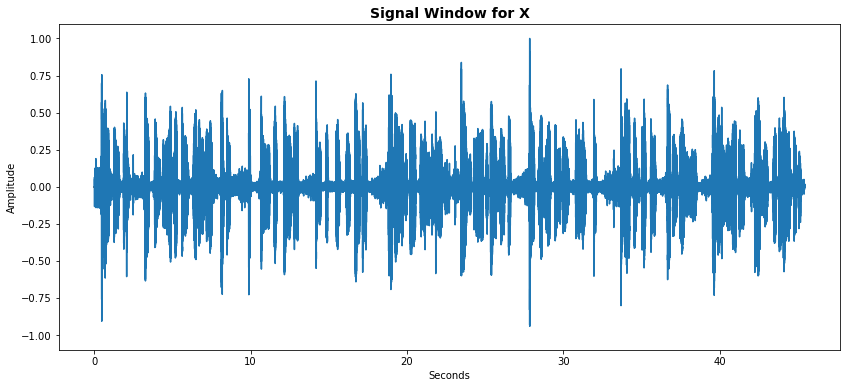

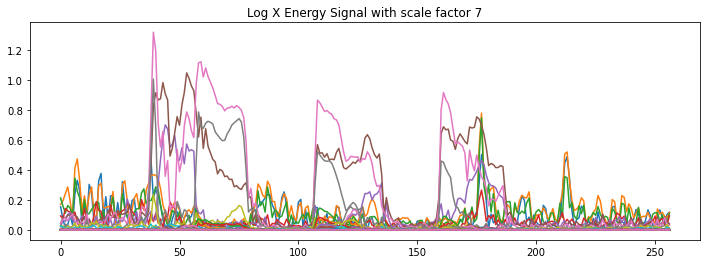

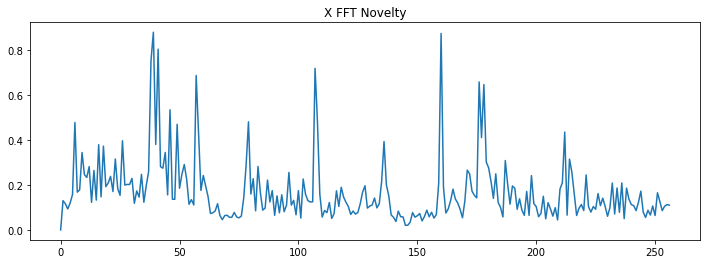

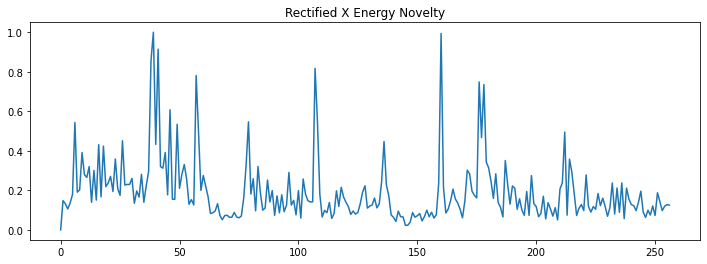

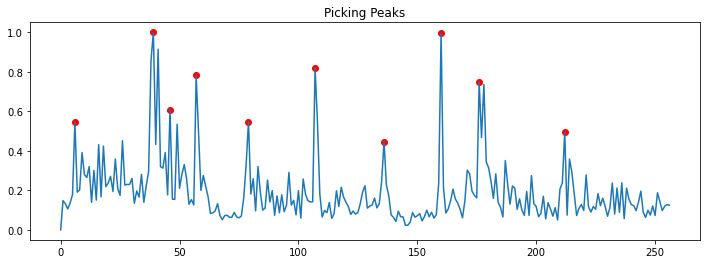

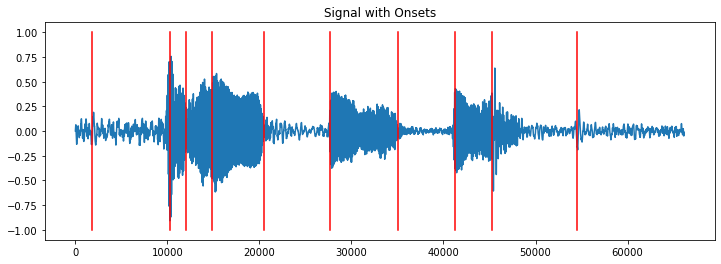

In [8]:
music, clicks = pre_analysis(audio_test)
Audio([music, clicks],rate=SR)

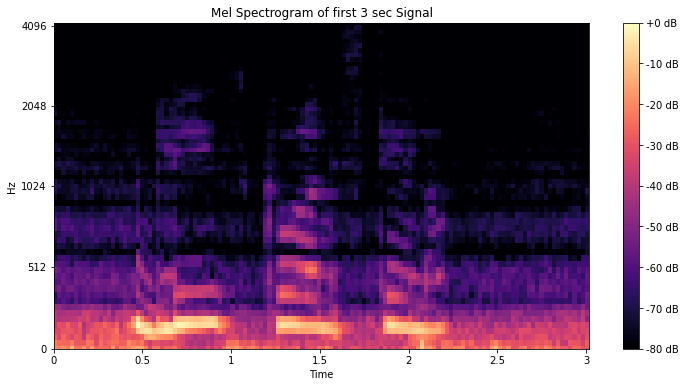

In [9]:
mel_spect = librosa.feature.melspectrogram(y=music, sr=SR, n_fft=1024, hop_length=512,n_mels=64)
mel_spect = librosa.power_to_db(mel_spect, ref=np.max)

plt.figure(figsize=(12,6))
librosa.display.specshow(mel_spect, y_axis='mel', fmax=4200, x_axis='time');
plt.title('Mel Spectrogram of first 3 sec Signal');
plt.colorbar(format='%+2.0f dB');

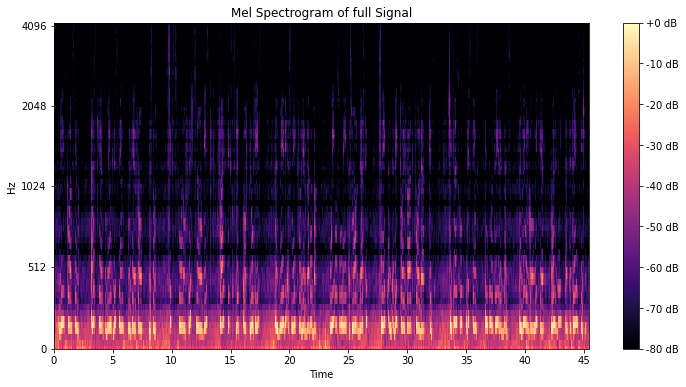

In [10]:
# get rid of white noise
audio_clean = applyAvgFilter(50,audio_test)
# normalize the signal
audio_clean = normalize(audio_clean)
mel_spect = librosa.feature.melspectrogram(y=audio_clean, sr=SR, n_fft=1024, hop_length=512,n_mels=64)
mel_spect = librosa.power_to_db(mel_spect, ref=np.max)

plt.figure(figsize=(12,6))
librosa.display.specshow(mel_spect, y_axis='mel', fmax=4200, x_axis='time');
plt.title('Mel Spectrogram of full Signal');
plt.colorbar(format='%+2.0f dB');

FileNotFoundError: [Errno 2] No such file or directory: 'test_img/test.png'

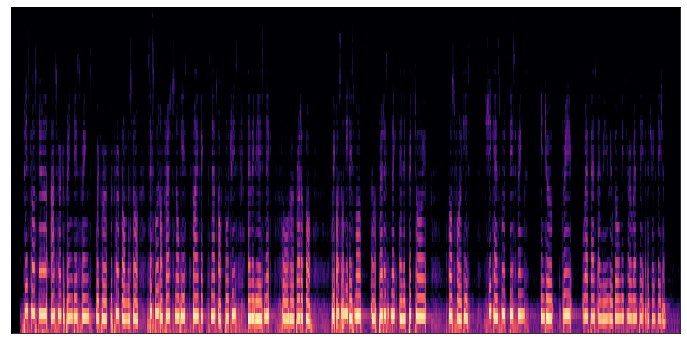

In [11]:
audio_test1 = readSignal("archive/recordings/recordings/cantonese1.mp3")
# get rid of white noise
audio_clean1 = applyAvgFilter(50,audio_test1)
# normalize the signal
audio_clean1 = normalize(audio_clean1)
mel_spect = librosa.feature.melspectrogram(y=audio_clean1, sr=SR, n_fft=1024, hop_length=512,n_mels=64)
mel_spect = librosa.power_to_db(mel_spect, ref=np.max)

fig = plt.figure(figsize=(12,6))
librosa.display.specshow(mel_spect, fmax=4200);
fig.savefig('test_img/test.png')
plt.title('Mel Spectrogram of full cantonese Signal');
plt.colorbar(format='%+2.0f dB');


In [12]:
import pandas as pd

# for testing
df = pd.read_csv('archive/speakers_all.csv')
#data = data.loc[data["file_missing?"] != True]
print(df.shape) 
data = df.loc[df["file_missing?"] != True]
print(data.shape)
data_test = data[:5]
print(data_test.shape)

(2172, 12)
(2140, 12)
(5, 12)


In [13]:
def process_img(file_path, current_index):
    # read csv file
    df = pd.read_csv(file_path+"archive/speakers_all.csv")
    # get rid of rows that has no recording
    data = df.loc[df["file_missing?"] != True]
    data = data[(current_index-32)+1:] ## adjusted for restarting the code
    counter=0
    for index, row in data.iterrows():
        #print(row['filename'])
        counter += 1
        total_img = data.shape[0]
        print("current Progress: ", counter/total_img)
        print("index:", index)
        audio = readSignal(file_path+"archive/recordings/recordings/"+row['filename']+".mp3")
        # get rid of white noise
        audio_clean1 = applyAvgFilter(50,audio)
        # normalize the signal 
        audio_clean1 = normalize(audio_clean1)
        mel_spect = librosa.feature.melspectrogram(y=audio_clean1, sr=SR, n_fft=1024, hop_length=512,n_mels=64)
        mel_spect = librosa.power_to_db(mel_spect, ref=np.max)
        librosa.display.specshow(mel_spect, fmax=4200)
        #save file
        fig = plt.savefig('test_img2/'+row['filename']+'.png')
        # fig.savefig('test_img/'+row['filename']+'.png')

# starting value: 32


current Progress:  0.0006238303181534623
index: 569
current Progress:  0.0012476606363069245
index: 570
current Progress:  0.0018714909544603868
index: 571
current Progress:  0.002495321272613849
index: 572
current Progress:  0.0031191515907673115
index: 573
current Progress:  0.0037429819089207735
index: 574
current Progress:  0.004366812227074236
index: 575
current Progress:  0.004990642545227698
index: 576
current Progress:  0.0056144728633811605
index: 577
current Progress:  0.006238303181534623
index: 578
current Progress:  0.006862133499688085
index: 579
current Progress:  0.007485963817841547
index: 580
current Progress:  0.008109794135995009
index: 581
current Progress:  0.008733624454148471
index: 582
current Progress:  0.009357454772301934
index: 583
current Progress:  0.009981285090455396
index: 584
current Progress:  0.010605115408608859
index: 585
current Progress:  0.011228945726762321
index: 586
current Progress:  0.011852776044915784
index: 587
current Progress:  0.0124

KeyboardInterrupt: 

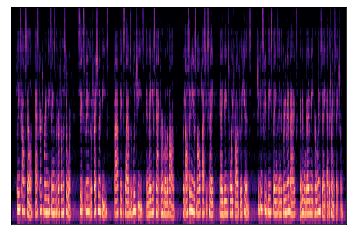

In [14]:
process_img('',568)

# index = 1120